


# 2D Burgers Equation

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes - 2D Burgers -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb)

**My Notes**:

* I had some serious stability issues from the time stepper. The CFL Condition is important!
* The code started to get a bit cumbersome, so I used a custom state + abstract functions.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 
\nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{aligned}
$$ (eq:2d_burgers)

where $\nu$ is the diffusivity. Here, we are advised to:
* Diffusion Term - 2nd order accurate central difference scheme
* Advection Term - 1st order accuracy backwards difference scheme
* Time Step - 1st order temporal scheme (Euler).
* Initialization - same hat
* Boundaries - 1's everywhere

## Domain

In [2]:
nx, ny = 41, 41
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [3]:
domain = Domain.from_numpoints(xmin=(xmin, ymin), xmax=(xmax, ymax), N=(nx, ny))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Nx: (41, 41)
Lx: (2.0, 2.0)
dx: (0.05, 0.05)
Size: (41, 41)
nDims: 2
Grid Size: (41, 41, 2)
Cell Volume: 0.0025000000000000005


### Initial Conditions

We're doing the same hat initialization as before.

$$
\begin{aligned}
\mathcal{IC}[u],\mathcal{IC}[v] &=
\begin{cases}
2 && \text{for }x,y \in (0.5, 1)\times(0.5,1) \\
1 && \text{everywhere else}
\end{cases}
\end{aligned}
$$

In [4]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.ones(domain.size, dtype=jnp.float64)
    u = u.at[
        int(0.5 / domain.dx[0]) : int(1 / domain.dx[0] + 1),
        int(0.5 / domain.dx[1]) : int(1 / domain.dx[1] + 1),
    ].set(2.0)
    return u

In [5]:
domain.size

(41, 41)

In [6]:
u_init = init_u0(domain)
v_init = init_u0(domain)

In [7]:
grid = domain.grid

In [8]:
u_init.shape

(41, 41)

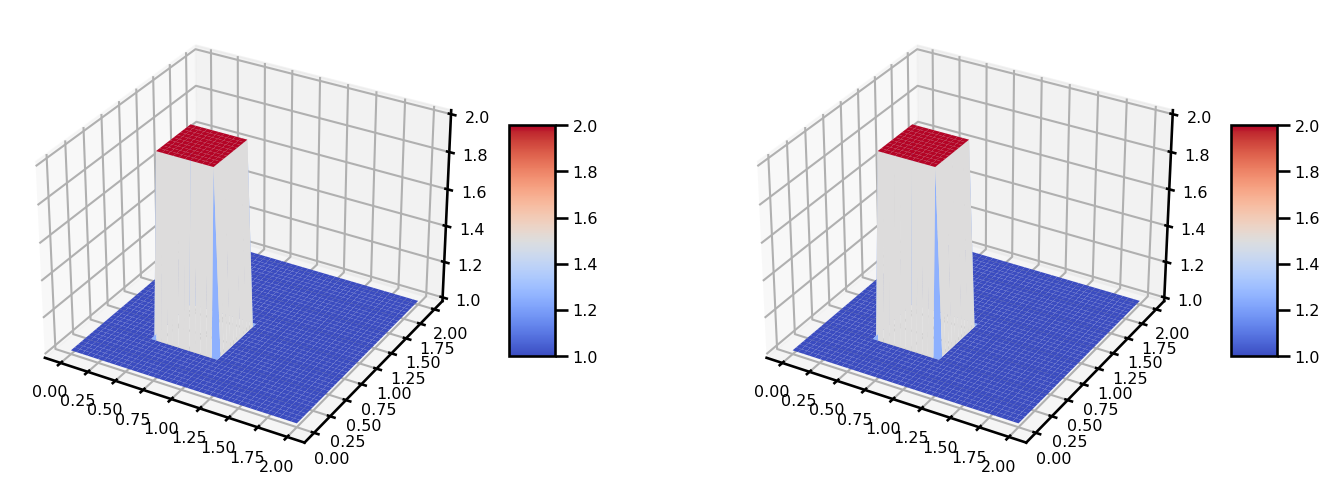

In [9]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], v_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

### Boundary Conditions

We are using the same boundary conditions as before, 1's everywhere. 

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

Note, we use the same BCs for both $u$ and $v$.

In [10]:
def bc_fn(u: Array) -> Array:
    u = u.at[0, :].set(1.0)
    u = u.at[-1, :].set(1.0)
    u = u.at[:, 0].set(1.0)
    u = u.at[:, -1].set(1.0)
    return u

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
D^-{2}_x[u] &:= \frac{\partial^2 u}{\partial x^2} \\
D^-{2}_y[u] &:= \frac{\partial^2 u}{\partial y^2} 
\end{aligned}
$$ (eq:2dnadvection)

where $D^2$ is the 2nd order accurate central difference method.

It's starting to get a bit cumbersome to put everything into a single equation, so we will start making functions for each other terms.

#### State

So for the "state", we need access to 2 variables and 1 constant: $u$, $v$, $\nu$. So we will create a "container" to hold these objects. A natural option is to use a NamedTuple. This is an immutable object that we can just use to pass around.

**Bonus**: Notice I used a nice python trick to create the state using a convenience function. This particular function initializes the state from a function that we pass through it.

In [11]:
from typing import Optional, NamedTuple, Callable
from dataclasses import dataclass


class State(NamedTuple):
    u: Array
    v: Array

    @classmethod
    def init_state(cls, domain, init_f: Callable):
        u = init_f(domain)
        v = init_f(domain)

        return cls(u=u, v=v)


class Params(NamedTuple):
    domain: Domain
    nu: int

In [12]:
state_init = State.init_state(domain, init_u0)
nu = 0.001
params = Params(domain=domain, nu=nu)

u_messed = state_init.u + 0.005
v_messed = state_init.v - 0.005

# update state (manually)
state_update = State(u=u_messed, v=v_messed)

# update state (convenience function)
state_update_ = eqx.tree_at(lambda x: x.u, state_init, u_messed)
state_update__ = eqx.tree_at(lambda x: x.v, state_update_, v_messed)
# state_update_ = State.update_state(state_init, u=state_init.u, v=state_init.v)

assert state_update == state_update__

#### Advection Term

We have the advection term for both $u$ and $v$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 0 \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 0
\end{aligned}
$$

They recommend that we use the 1st order accurate backward difference scheme. We will make a generic advection function term that should work for both $u$ and $v$.

In [13]:
from jaxsw._src.operators.functional import advection

# advection.advection_2D?

In [15]:
out = advection.advection_2D(u_init, u_init, v_init, domain.dx)

assert out.shape == u_init.shape == v_init.shape
out.min(), out.max()

(Array(-20., dtype=float64), Array(80., dtype=float64))

#### Diffusion Term

We have the diffusion term for both methods:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= 
\nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &= 
\nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right) \\
\end{aligned}
$$

They recommend that we use the 2nd order accurate central difference scheme. We will make a generic diffusion term that should work for both $u$ and $v$.

In [16]:
from jaxsw._src.operators.functional import diffusion

# diffusion.diffusion_2D?

In [17]:
out = diffusion.diffusion_2D(u_init, diffusivity=0.001, step_size=domain.dx)

assert out.shape == u_init.shape
out.min(), out.max()

(Array(-0.8, dtype=float64), Array(0.4, dtype=float64))

#### Final Combination

Now, we can create the equation of motion that for the burgers equation.

In [51]:
class Burgers2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Burgers Equation

        Equation:
            ∂u/∂t + u ∂u/∂x + v ∂u/∂y = ν (∂²u/∂x² + ∂²u/∂y²)
            ∂v/∂t + u ∂v/∂x + v ∂v/∂y = ν (∂²v/∂x² + ∂²v/∂y²)
        """
        # unpack state
        u, v = state.u, state.v

        # unpack params
        nu, domain = args.nu, args.domain

        # Apply Boundary Conditions
        u = bc_fn(u)
        v = bc_fn(v)

        # u advection-diffusion
        u_advection = advection.advection_2D(u, u, v, domain.dx)
        # u_advection = advection.advection_upwind_2D(
        #     u=u, a=u, b=v, step_size=domain.dx, accuracy=2
        # )
        u_diffusion = diffusion.diffusion_2D(u, nu, domain.dx, accuracy=2)

        # v advection, diffusion
        v_advection = advection.advection_2D(v, u, v, domain.dx)
        # v_advection = advection.advection_upwind_2D(
        #     u=v, a=u, b=v, step_size=domain.dx, accuracy=2
        # )
        v_diffusion = diffusion.diffusion_2D(v, nu, domain.dx, accuracy=2)

        # combine terms
        u_rhs = -u_advection + u_diffusion
        v_rhs = -v_advection + v_diffusion

        # update state
        state = eqx.tree_at(lambda x: x.u, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v, state, v_rhs)
        return state

In [52]:
# SPATIAL DISCRETIZATION
# initialize state
state_init = State.init_state(domain, init_u0)
params_init = Params(domain, nu)

# right hand side
state_out = Burgers2D.equation_of_motion(0, state_init, params_init)

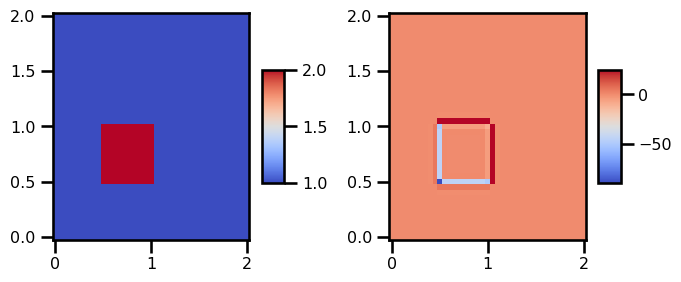

In [53]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
surf = ax[0].pcolormesh(
    domain.grid[..., 0], domain.grid[..., 1], state_init.u, cmap=cm.coolwarm
)
plt.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].pcolormesh(
    domain.grid[..., 0], domain.grid[..., 1], state_out.u, cmap=cm.coolwarm
)
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

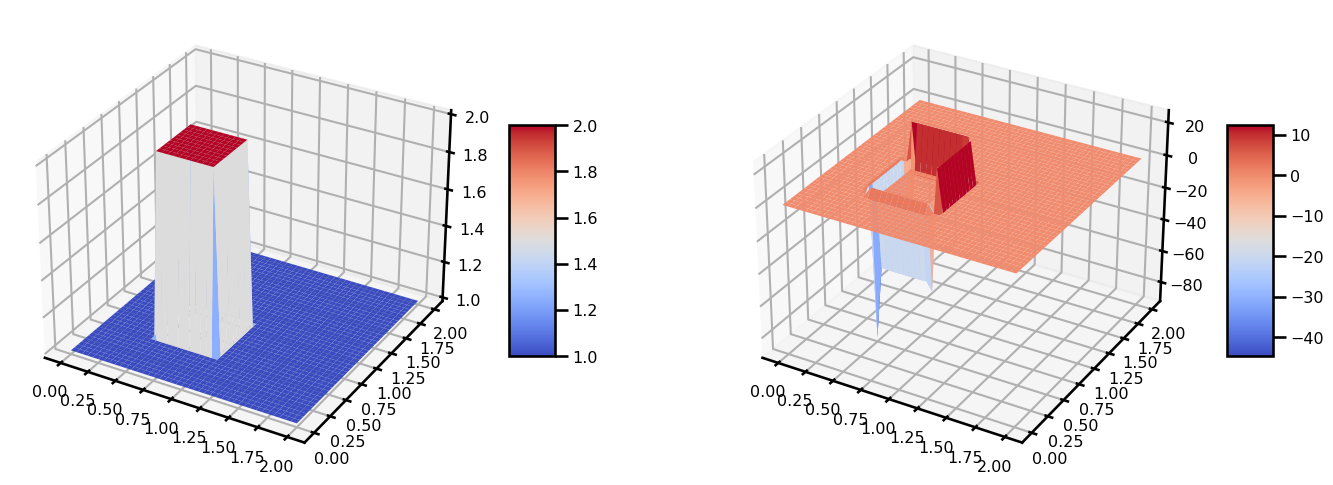

In [54]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], state_init.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], state_out.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## Time Stepping

Here we use the Euler method with a constant stepsize.

#### CFL Condition

In [55]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

sigma = 0.0009
nu = 0.01
dt = sigma * domain.dx[0] * domain.dx[1] / nu
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = 0.5  # (np.arange(120) * dt).max()
num_save = 20

Step Size (dt): 2.2500e-04


In [56]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = Burgers2D(t_domain=t_domain, saveat=saveat)

### Integration

In [57]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# SPATIAL DISCRETIZATION
state_init = State.init_state(domain, init_u0)
params_init = Params(domain, nu)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [58]:
da_sol = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), np.asarray(sol.ys[0])),
        "v": (("time", "x", "y"), np.asarray(sol.ys[1])),
    },
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "y": (["y"], np.asarray(domain.coords[1])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "nonlinear_convection", "sigma": sigma},
)
da_sol

<xarray.Dataset>
Dimensions:  (time: 20, x: 41, y: 41)
Coordinates:
  * x        (x) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 1.8 1.85 1.9 1.95 2.0
  * y        (y) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 1.8 1.85 1.9 1.95 2.0
  * time     (time) float64 0.0 0.02632 0.05263 0.07895 ... 0.4474 0.4737 0.5
Data variables:
    u        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.0 1.0 1.0
    v        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.0 1.0 1.0
Attributes:
    pde:      nonlinear_convection
    sigma:    0.0009

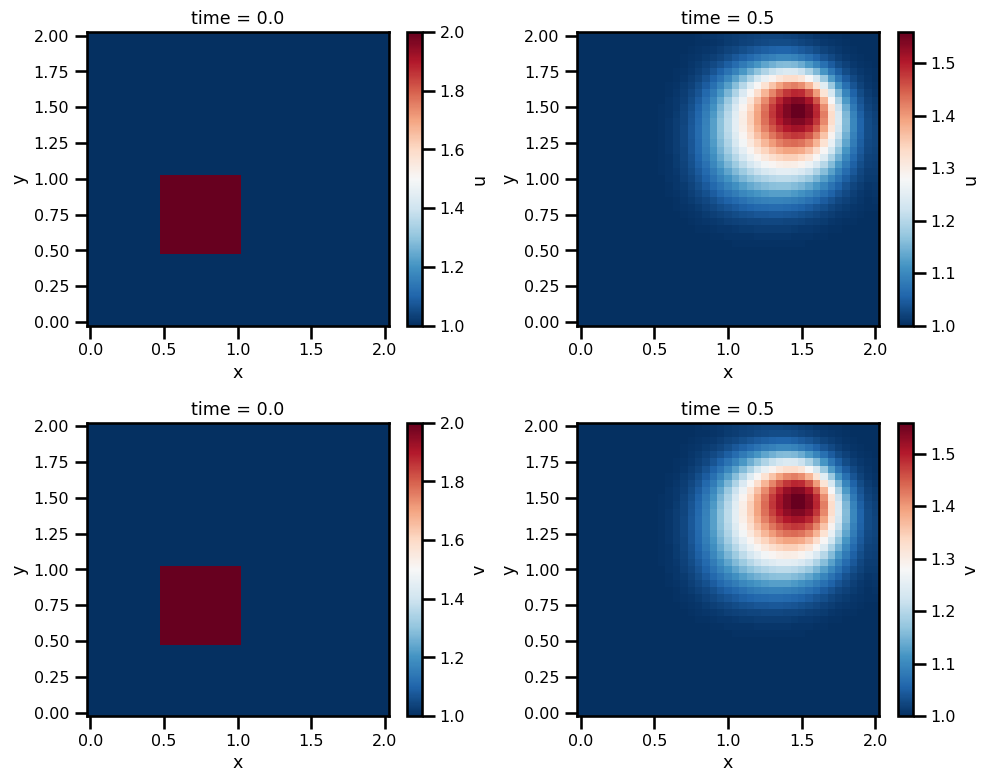

In [59]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

# U
da_sol.u.isel(time=0).T.plot.pcolormesh(ax=ax[0, 0], cmap="RdBu_r")
da_sol.u.isel(time=-1).T.plot.pcolormesh(ax=ax[0, 1], cmap="RdBu_r")

# V
da_sol.v.isel(time=0).T.plot.pcolormesh(ax=ax[1, 0], cmap="RdBu_r")
da_sol.v.isel(time=-1).T.plot.pcolormesh(ax=ax[1, 1], cmap="RdBu_r")

plt.tight_layout()
plt.show()

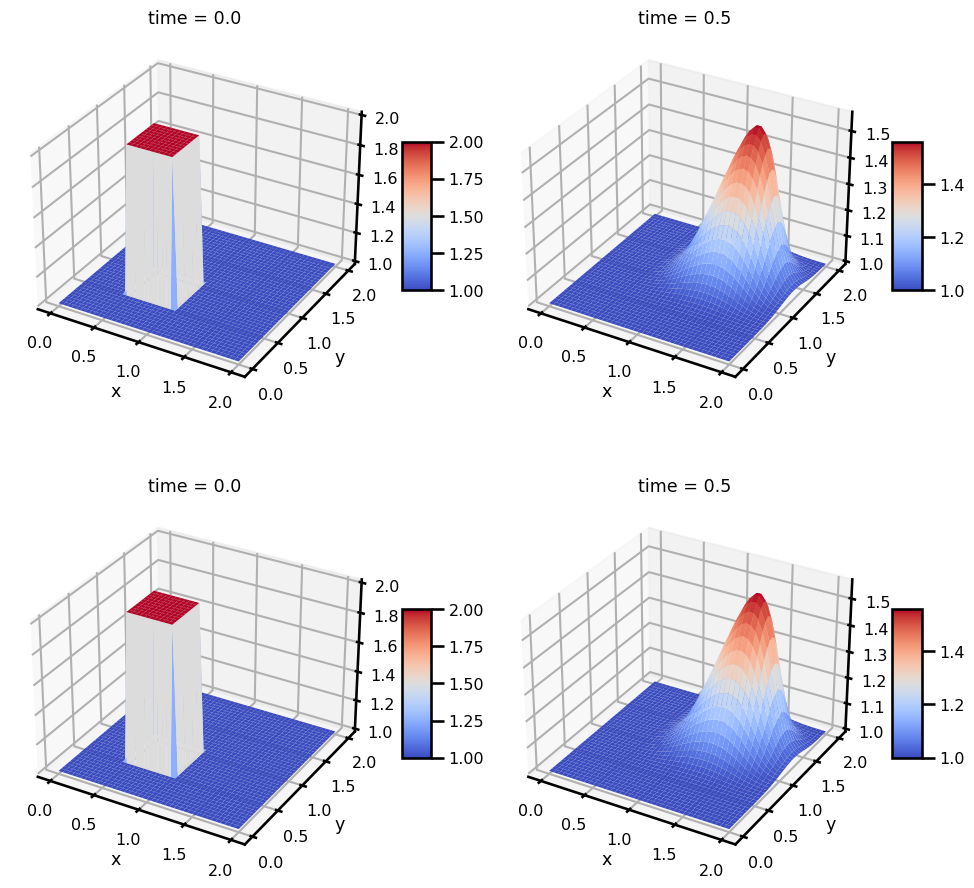

In [60]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, subplot_kw={"projection": "3d"}, figsize=(10, 10)
)

vmin = da_sol.min()
vmax = da_sol.max()

cbar_kwargs = dict(shrink=0.3, aspect=5)

# U
vmin = None  # da_sol.u.min()
vmax = None  # da_sol.u.max()

pts = da_sol.u.isel(time=0).T.plot.surface(
    ax=ax[0, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.u.isel(time=-1).T.plot.surface(
    ax=ax[0, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)

# V
vmin = None  # da_sol.v.min()
vmax = None  # da_sol.v.max()
pts = da_sol.v.isel(time=0).T.plot.surface(
    ax=ax[1, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.v.isel(time=-1).T.plot.surface(
    ax=ax[1, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
plt.tight_layout()
plt.show()